In [ ]:
import pandas as pd
import numpy as np
import os
import pandas_datareader as pdr
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from tensorflow import keras

In [ ]:
data = pd.read_csv(r"/content/ITC.csv")
# data = data._convert(numeric=True)

In [ ]:
data = data[['Close']]

In [ ]:
only_num = data[pd.to_numeric(data['Close'], errors='coerce').notnull()] # to delete the nonnumeric rows
data = data.reset_index()# sending the index inside

In [ ]:
only_num
data=only_num

In [ ]:
data.dropna()

,Close
0,5.583333
1,5.372222
2,5.200000
3,5.297777
4,5.202222
...,...
6960,447.200012
6961,451.149994
6962,453.500000
6963,449.950012


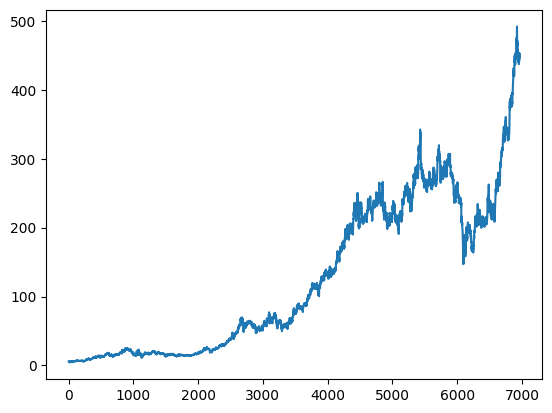

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(data).reshape(-1,1))
# data = np.array(data).reshape(-1,1)

In [ ]:
#slipt data for training and testing
training_size = int(len(data)*0.70)
test_size = len(data)-training_size
train_data,test_data = data[0:training_size,:],data[training_size:len(data):1]

In [ ]:
#preprocessing
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [ ]:
time_step = 30
X_train,Y_train= create_dataset(train_data,time_step)
X_test,Y_test= create_dataset(test_data,time_step)

In [ ]:
#reshpe input as [samples, time_step, features] which is required for lstm
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [ ]:
#create model
from tensorflow.keras.optimizers import Adam
model = Sequential()
units = 50
model.add(LSTM(units, return_sequences=True, input_shape=(time_step,1)))#100 for 100 days
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer="adam")


In [ ]:
history = model.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
152/152 [==============================] - 2s 10ms/step - loss: 1.4037e-05 - val_loss: 2.5536e-04
Epoch 2/100
152/152 [==============================] - 2s 10ms/step - loss: 1.4790e-05 - val_loss: 7.8408e-04
Epoch 3/100
152/152 [==============================] - 1s 10ms/step - loss: 1.5908e-05 - val_loss: 3.3355e-04
Epoch 4/100
152/152 [==============================] - 2s 10ms/step - loss: 1.6177e-05 - val_loss: 4.3027e-04
Epoch 5/100
152/152 [==============================] - 2s 16ms/step - loss: 1.5855e-05 - val_loss: 2.7641e-04
Epoch 6/100
152/152 [==============================] - 1s 10ms/step - loss: 1.3905e-05 - val_loss: 3.9474e-04
Epoch 7/100
152/152 [==============================] - 2s 10ms/step - loss: 1.6834e-05 - val_loss: 3.9647e-04
Epoch 8/100
152/152 [==============================] - 1s 10ms/step - loss: 1.4237e-05 - val_loss: 3.6250e-04
Epoch 9/100
152/152 [==============================] - 2s 10ms/step - loss: 1.5295e-05 - val_loss: 3.3976e-04
Epoch 10/1

In [ ]:
# metrics
train_predict = model.predict(X_train)
test_predict=model.predict(X_test)

65/65 [==============================] - 0s 4ms/step


In [ ]:
train_predict.shape

(4844, 1)

In [ ]:
train_predict = train_predict.reshape(train_predict.shape[0],train_predict.shape[1])
test_predict = test_predict.reshape(test_predict.shape[0],test_predict.shape[1])

In [ ]:
#back to original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
Y_train.shape


(4844,)

In [ ]:
train_predict.shape

(4844, 1)

In [ ]:
#calculate RMSE
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error
math.sqrt(mean_squared_error(Y_train, train_predict))

97.31862471037904

In [ ]:
math.sqrt(mean_squared_error(Y_test, test_predict))
print("Train data MSE: ", math.sqrt(mean_squared_error(Y_train,train_predict)))
print("Train data MAE: ", mean_absolute_error(Y_train,train_predict))
print("Test data MSE: ", math.sqrt(mean_squared_error(Y_test,test_predict)))
print("Test data MAE: ", mean_absolute_error(Y_test,test_predict))
def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
# mape = calculate_mape(Y_test,test_predict)
# plt.plot(history.history['mape'])
# print("Test mape : ",mape)


Train data MSE:  97.31862471037904
Train data MAE:  67.7111810754541
Test data MSE:  262.23821577250044
Test data MAE:  256.484109681561


KeyError: ignored

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize = (15, 4),dpi=2000)
plt.plot(scaler.inverse_transform(data))

# plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['original price','train_predictions','test_predictions'])
plt.xlabel('no. of days')
plt.ylabel('Closing price')

Text(0, 0.5, 'Closing price')

In [ ]:
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 30)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
days = 15

In [ ]:
lst_output=[]
n_steps=30
i=0
while(i<days):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.83730817]
31
[0.83730817]
32
[0.83730817]
33
[0.83730817]
34
[0.83730817]
35
[0.83730817]
36
[0.83730817]
37
[0.83730817]
38
[0.83730817]
39
[0.83730817]
40
[0.83730817]
41
[0.83730817]
42
[0.83730817]
43
[0.83730817]
44
[0.83730817]
45


In [ ]:
day_new = np.arange(len(data),len(data)+time_step)
day_pred=np.arange(len(data),len(data)+days)

In [ ]:
df = data.tolist()
df.extend(lst_output)

In [ ]:
index_newday=[]
for i in range(len(data),len(data)+1+len(day_pred)):
  index_newday.append(i)
index_newpred=[]
for i in range(len(data)+len(day_pred),len(data)+len(day_pred)+days):
  index_newpred.append(i)

In [ ]:
print(len(data)+len(day_pred)," ",index_newday[0], " ",len(index_newday))
np.append(data,lst_output[0])

6981   6966   16


array([0.0014229 , 0.00137916, 0.00142153, ..., 0.86270119, 0.86430901,
       0.7779367 ])

In [ ]:
lst_output

[[0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256],
 [0.7779366970062256]]

Text(0, 0.5, 'price')

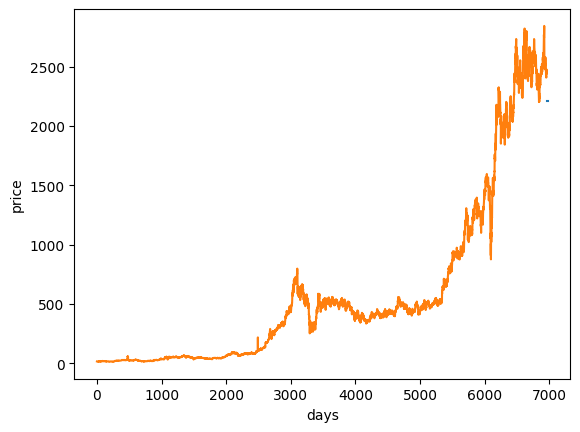

In [ ]:
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.plot(scaler.inverse_transform(data))
plt.xlabel("days")
plt.ylabel("price")

In [ ]:
last = scaler.inverse_transform(lst_output)
lst =[]
for x in last:
  lst.append(x[0])


lst

[2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097,
 2213.419967397097]

Text(0, 0.5, 'price')

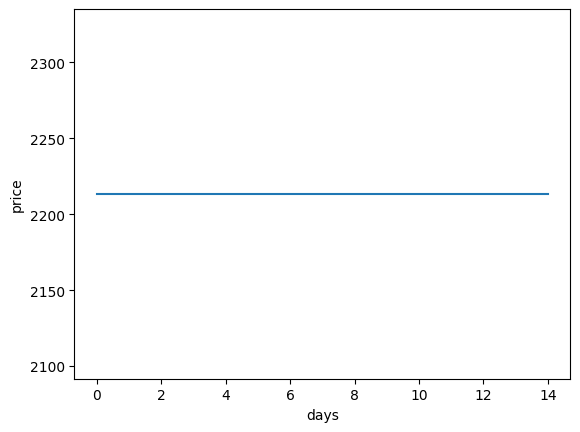

In [ ]:
plt.plot(lst)
plt.xlabel("days")
plt.ylabel("price")

In [ ]:
print("predicted after 15 days (recursive prediction) : ",scaler.inverse_transform([lst_output[-1]]))


predicted after 15 days (recursive prediction) :  [[2213.4199674]]
